In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=0, aug_alpha=True),LossTracker(),SaveBest('weights/best_ie1a.h5'),EarlyStopping(10)])

1: Train=576.8991427612305 Valid=420.992802734375
2: Train=414.4444232177734 Valid=388.7903308105469
3: Train=373.49641845703127 Valid=347.6967346191406
4: Train=290.9184240722656 Valid=282.3200225830078
5: Train=319.98613006591796 Valid=252.28487182617187
6: Train=246.62159133911132 Valid=276.96413482666014
7: Train=273.31073120117185 Valid=271.8667398071289
8: Train=228.0942756652832 Valid=216.63497497558595
9: Train=208.88972213745117 Valid=198.371748046875
10: Train=230.71350463867188 Valid=216.40148193359374
11: Train=158.6495960998535 Valid=160.2049725341797
12: Train=130.27944297790526 Valid=148.59487518310547
13: Train=149.93045082092286 Valid=147.41337814331055
14: Train=174.43209243774413 Valid=189.3846694946289
15: Train=180.41693283081054 Valid=182.50984832763672
16: Train=148.19225219726562 Valid=182.30428649902345
17: Train=236.40567581176757 Valid=210.46321838378907
18: Train=195.87700744628907 Valid=228.28200500488282
19: Train=219.82221786499022 Valid=189.7893472290039

In [8]:
model.save('weights/Inferno_Test_exact_bm1a.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm1a.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,1,1.0
1,1,1.0
2,7,1.0
3,4,1.0
4,3,1.0


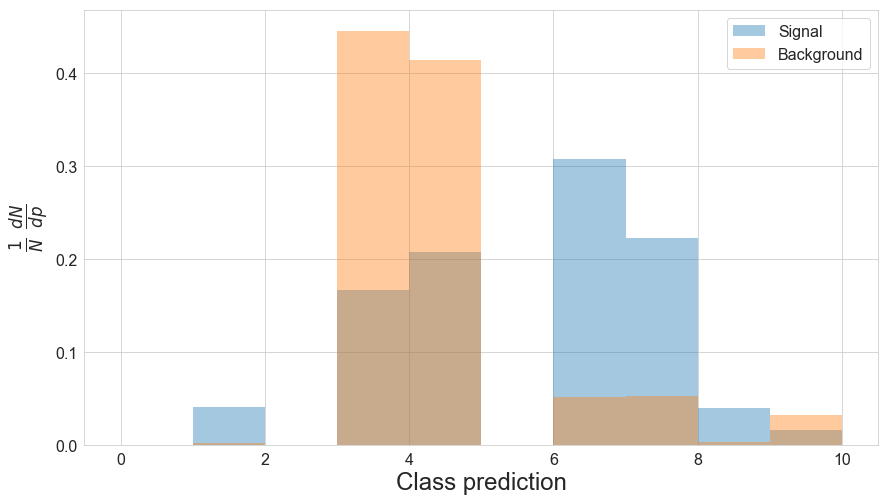

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,1,1.0,1
1,1,1.0,1
2,7,1.0,7
3,4,1.0,4
4,3,1.0,3


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([8.0000e-06, 4.0312e-02, 2.0000e-13, 1.6702e-01, 2.0730e-01, 2.0000e-13,
         3.0724e-01, 2.2230e-01, 3.9474e-02, 1.6342e-02]),
 tensor([2.0000e-13, 2.2920e-03, 2.0000e-13, 4.4591e-01, 4.1408e-01, 2.0000e-13,
         5.1176e-02, 5.2082e-02, 2.7180e-03, 3.1742e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([4.0000e-04, 4.3076e+00, 2.1000e-10, 4.5426e+02, 4.2445e+02, 2.1000e-10,
         6.6538e+01, 6.3197e+01, 4.6917e+00, 3.2559e+01]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([21.53105545, 21.42332458, 21.31998825, 21.22079086, 21.12584114,
       21.03536606, 20.94860077, 20.86594772, 20.78766632, 20.7129097 ,
       20.64235687, 20.57547951, 20.512043  , 20.45286179, 20.39732361,
       20.34546661, 20.29682922, 20.25238419, 20.21099854, 20.17329407,
       20.13931656, 20.10840797, 20.0809288 , 20.05717468, 20.03624344,
       20.01900101, 20.00503922, 19.99386597, 19.98603439, 19.98137665,
       19.97970581, 19.98111343, 19.98590088, 19.99338722, 20.00388336,
       20.01768494, 20.03425407, 20.05378723, 20.07562065, 20.10079575,
       20.12864685, 20.15911674, 20.19319916, 20.22915459, 20.26831245,
       20.30983353, 20.35407066, 20.40102005, 20.45046234, 20.50257111,
       20.55757904, 20.61473083, 20.67500114, 20.73659134, 20.80186081,
       20.86903   , 20.93856812, 21.01081467, 21.08509445, 21.16208649,
       21.24151039])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

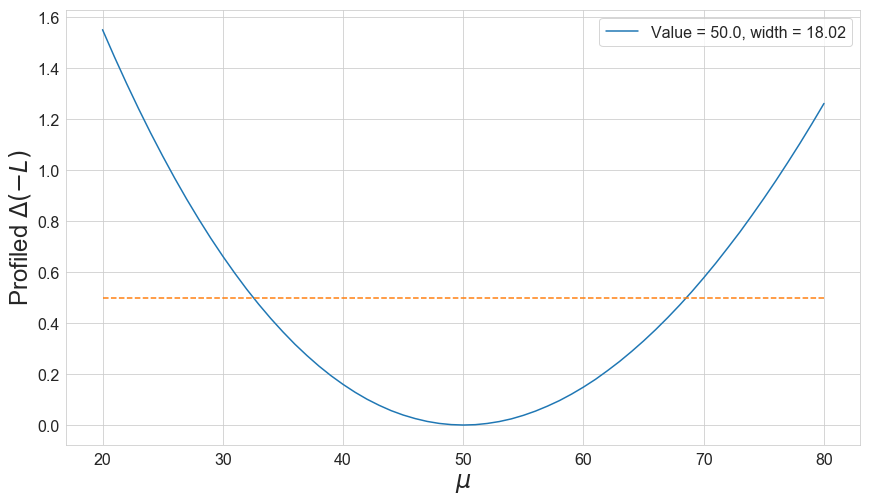

In [23]:
plot_likelihood(y-y.min())

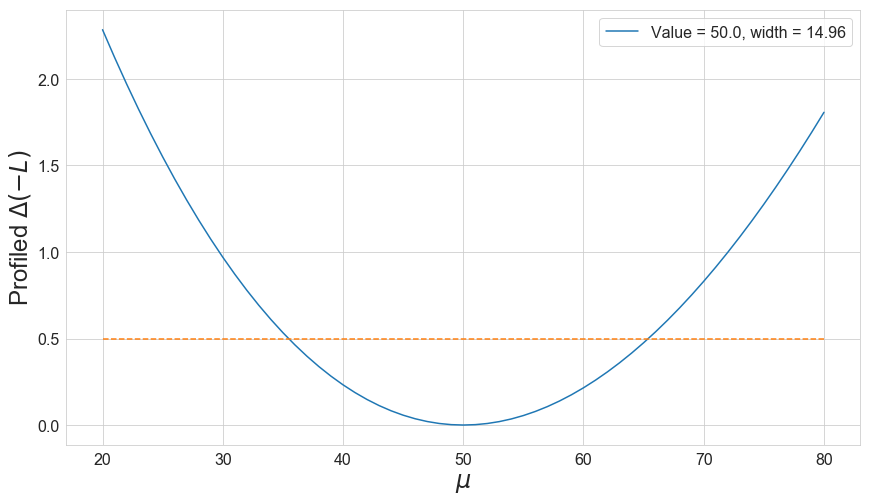

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,1,1.0,1,1,1,1,1,1,1,1,1,1,1
1,1,1.0,1,1,1,1,1,1,1,1,1,1,1
2,7,1.0,7,7,7,7,7,7,7,7,7,7,7
3,4,1.0,4,4,4,4,4,4,4,4,4,4,4
4,3,1.0,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999996,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999997,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999998,3,0.0,3,3,3,3,3,3,3,3,3,3,3


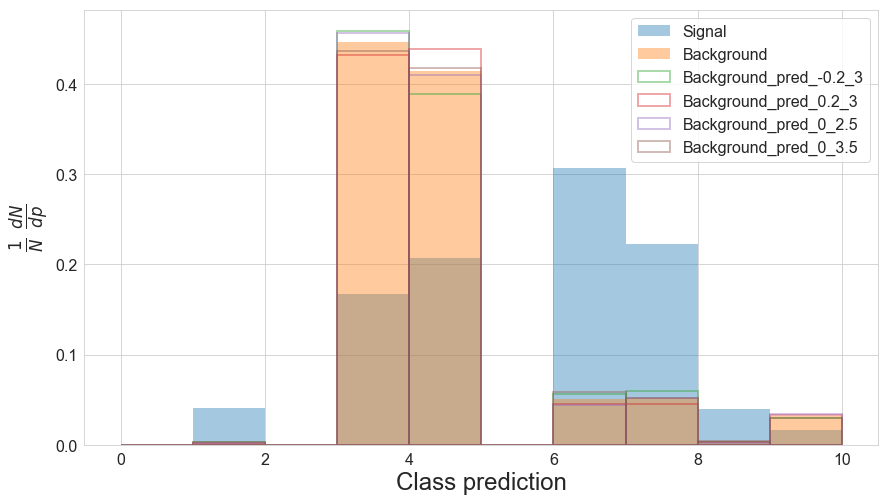

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([-2.7374e-14,  1.9620e-03,  2.0000e-13,  4.6914e-01,  3.8509e-01,
         2.0000e-13,  5.0262e-02,  5.9208e-02,  2.0480e-03,  3.2292e-02])
tensor([-2.7374e-14,  2.6280e-03,  2.0000e-13,  4.5893e-01,  3.8905e-01,
         2.0000e-13,  5.6806e-02,  5.9640e-02,  2.8800e-03,  3.0068e-02])
tensor([-2.7374e-14,  3.4020e-03,  2.0000e-13,  4.4908e-01,  3.9215e-01,
         2.0000e-13,  6.3702e-02,  5.9592e-02,  3.9300e-03,  2.8150e-02])
tensor([2.0000e-13, 1.6260e-03, 2.0000e-13, 4.5612e-01, 4.1012e-01, 2.0000e-13,
        4.4632e-02, 5.1650e-02, 1.8860e-03, 3.3966e-02])
tensor([2.0000e-13, 2.2920e-03, 2.0000e-13, 4.4591e-01, 4.1408e-01, 2.0000e-13,
        5.1176e-02, 5.2082e-02, 2.7180e-03, 3.1742e-02])
tensor([2.0000e-13, 3.0660e-03, 2.0000e-13, 4.3606e-01, 4.1718e-01, 2.0000e-13,
        5.8072e-02, 5.2034e-02, 3.7680e-03, 2.9824e-02])
tensor([4.0000e-06, 1.3540e-03, 2.0000e-13, 4.4257e-01, 4.3508e-01, 2.0000e-13,
        3.9122e-02, 4.4922e-02, 1.7560e-03, 3.5192e-02])
tensor([4.0

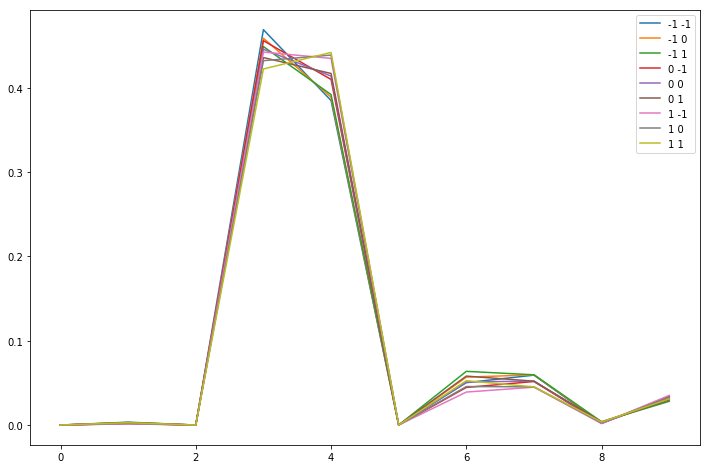

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

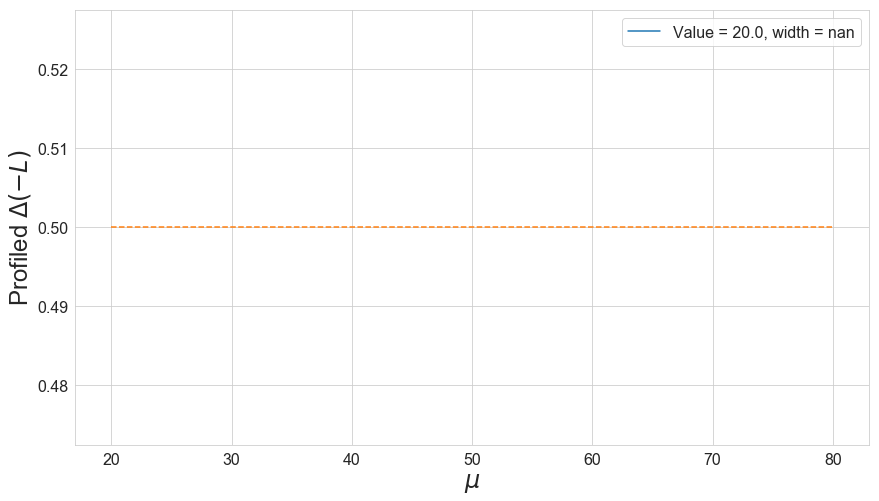

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

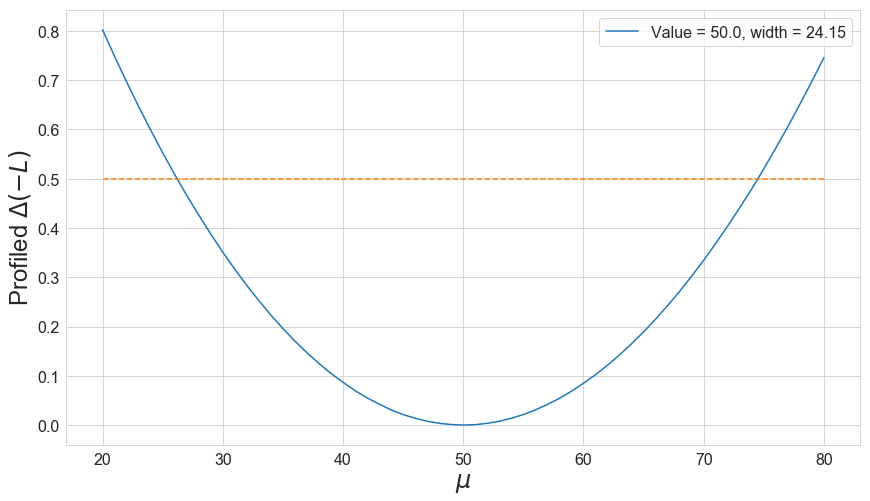

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

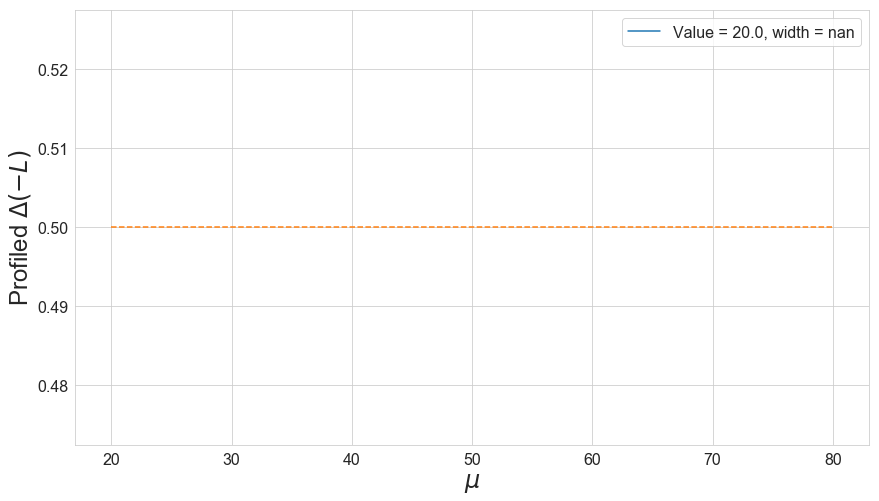

In [42]:
plot_likelihood(nll-nll.min())